# Polscope with phase processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import time

import glob
from PIL import Image
import os
from skimage import io
from scipy.ndimage import uniform_filter

import waveorder as wo


%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background


### Experiment parameters

In [2]:
n_media       = 1.512                   # refractive index of the immersed media for objective (oil: 1.512, water: 1.33, air: 1)
lambda_illu   = 0.532               # illumination wavelength (um)
mag           = 63                  # magnification of the microscope                      
NA_obj        = 1.47                # detection NA of the objective
NA_illu       = 0.9                 # illumination NA of the condenser
N_defocus     = 45                   # number of defocus images
N_channel     = 5                   # number of Polscope channels
z_step        = 0.25               # z_step of the stack
z_defocus     = -(np.r_[:N_defocus]-22)*z_step
chi           = 0.1*2*np.pi        # swing of the LC
ps            = 6.45/mag            # effective pixel size at the sample plane (cam pix/mag in um)
cali          = True                # correction for S1/S2 Polscope reconstruction (does not affect phase)
bg_option     = 'local_fit'         # background correction method for Polscope recon (does not affect phase)
data_path     = '/gpfs/CompMicro/Spinningdisk/RawData/virtualstaining/2019_02_15_kidney_slice/SMS_2018_1227_1433_1/2-Pos_002_026/'        # data path
bg_path       = '/gpfs/CompMicro/Spinningdisk/RawData/virtualstaining/2019_02_15_kidney_slice/BG_2019_0215_1337_1/Pos0/'           # background data path
# output_path   = '/gpfs/CompMicro/Spinningdisk/Processed/LiHao/data_processing/2019_04_11_U2OS_dividing_2/dividing_3/'      # output image path
use_gpu       = True
gpu_id        = 0

In [3]:
# metadata file loading

import json

f = open(data_path+'metadata.txt')
data = json.load(f)
N_pos = len(data['Summary']['InitialPositionList'])
filedir = []
for i in range(N_pos):
    filedir.append(data_path+data['Summary']['InitialPositionList'][i]['Label']+'/')

f.close()

In [4]:
# position number
filedir[122]

'/gpfs/CompMicro/Spinningdisk/RawData/virtualstaining/2019_02_15_kidney_slice/SMS_2018_1227_1433_1/2-Pos_002_026/2-Pos_002_026/'

In [5]:
# solver option

deconv = 'TV'         # deconvolution method

if deconv == 'Tikhonov':
    reg_u = 1e-1      # absorption regularizer (larger the smoother but less contrast)
    reg_p = 1e-3      # phase regularizer
    
elif deconv == 'TV':
    reg_u = 1e-5      # absorption regularizer (larger the smoother but less contrast)
    reg_p = 1e-5      # phase regularizer
    lambda_u = 1e-2   # absorption regularizer
    lambda_p = 1e-2   # phase regularizer
    rho = 1e-2           # rho coefficient of ADMM algorithm (the larger the less noisy and contrast)
    itr = 10          # number of ADMM iteration (10 is usually good)
    verbose = False   # report of the iteration number or not

In [6]:
filedir = data_path + '*PolState*.tif'
filedir_bg = bg_path + '*State*.tif'
files = sorted(glob.glob(filedir), key=wo.numericalSort)
files_bg = sorted(glob.glob(filedir_bg), key=wo.numericalSort)

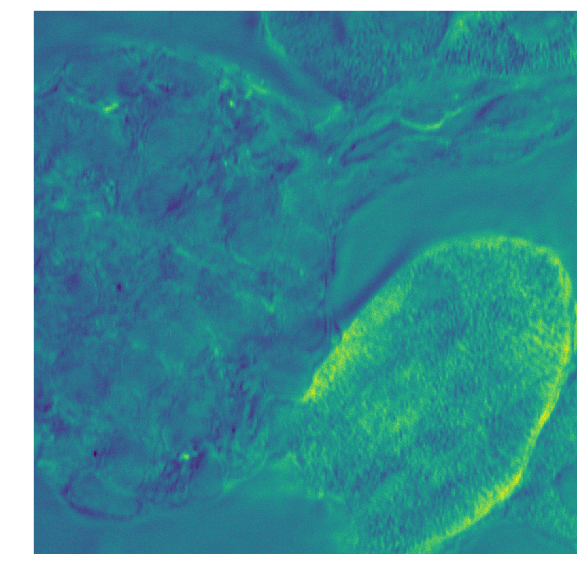

In [7]:
# select a FOV for processing

Ns = 800
Ms = 800
n_start = [800, 100] 


plt.figure(figsize=(10,10))
plt.imshow(plt.imread(files[60]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms])


### Load data

In [10]:
# Load files

Nimg = N_defocus*N_channel

# Load background images
Nbg = len(files_bg)
I_bg_pre = []

for i in range(0, Nbg):
    Itemp = io.imread(files_bg[i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
    I_bg_pre.append(Itemp)

I_bg_pre = np.array(I_bg_pre)
I_bg = wo.intensity_mapping(I_bg_pre)

I_meas_pre =[]

for i in range(0, Nimg):
    Itemp = io.imread(files[i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
    I_meas_pre.append(Itemp)
    
I_meas_pre = np.array(I_meas_pre)
I_meas_pre = np.transpose(I_meas_pre.reshape((N_channel, N_defocus, Ns, Ms)), (0,2,3,1))

# intensity mapping to match the theory
I_meas = np.zeros_like(I_meas_pre)
for i in range(N_defocus):
    I_meas[:,:,:,i] = wo.intensity_mapping(I_meas_pre[:,:,:,i])

### Polarization reconstruction

In [8]:
# Reconstruct parameters


setup = wo.waveorder_microscopy((Ns,Ms), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi,\
                                n_media=n_media, cali=cali, bg_option=bg_option, use_gpu=use_gpu, gpu_id=gpu_id)




In [11]:
S_image_recon = setup.Stokes_recon(I_meas)
S_bg_recon = setup.Stokes_recon(I_bg)
S_image_tm = setup.Stokes_transform(S_image_recon)
S_bg_tm = setup.Stokes_transform(S_bg_recon)
S_image_tm = setup.Polscope_bg_correction(S_image_tm, S_bg_tm)  
Recon_para = setup.Polarization_recon(S_image_tm)

In [12]:
wo.parallel_4D_viewer(np.transpose(Recon_para,(3,0,1,2)), num_col=2, size=10)

interactive(children=(IntSlider(value=0, description='stack_idx', max=44), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [42]:
wo.image_stack_viewer(np.transpose(np.clip(Recon_para[2],0.9,1.1),(2,0,1)), size=(10,10))

interactive(children=(IntSlider(value=0, description='stack_idx', max=44), Output()), _dom_classes=('widget-in…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

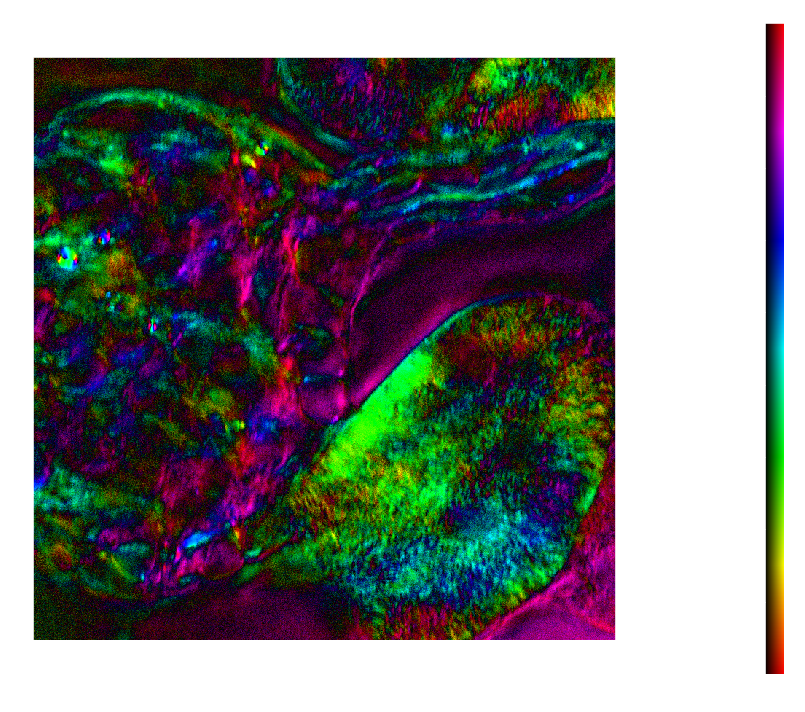

In [41]:
wo.plot_hsv([Recon_para[1,:,:,22], np.clip(Recon_para[0,:,:,22],0,2*np.pi*3e-3/lambda_illu)],max_val=1, size=10)

In [16]:
import gc
import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()

### Phase reconstruction

Number of iteration computed (1 / 50)
Number of iteration computed (2 / 50)
Number of iteration computed (3 / 50)
Number of iteration computed (4 / 50)
Number of iteration computed (5 / 50)
Number of iteration computed (6 / 50)
Number of iteration computed (7 / 50)
Number of iteration computed (8 / 50)
Number of iteration computed (9 / 50)
Number of iteration computed (10 / 50)
Number of iteration computed (11 / 50)
Number of iteration computed (12 / 50)
Number of iteration computed (13 / 50)
Number of iteration computed (14 / 50)
Number of iteration computed (15 / 50)
Number of iteration computed (16 / 50)
Number of iteration computed (17 / 50)
Number of iteration computed (18 / 50)
Number of iteration computed (19 / 50)
Number of iteration computed (20 / 50)
Number of iteration computed (21 / 50)
Number of iteration computed (22 / 50)
Number of iteration computed (23 / 50)
Number of iteration computed (24 / 50)
Number of iteration computed (25 / 50)
Number of iteration computed (26 /

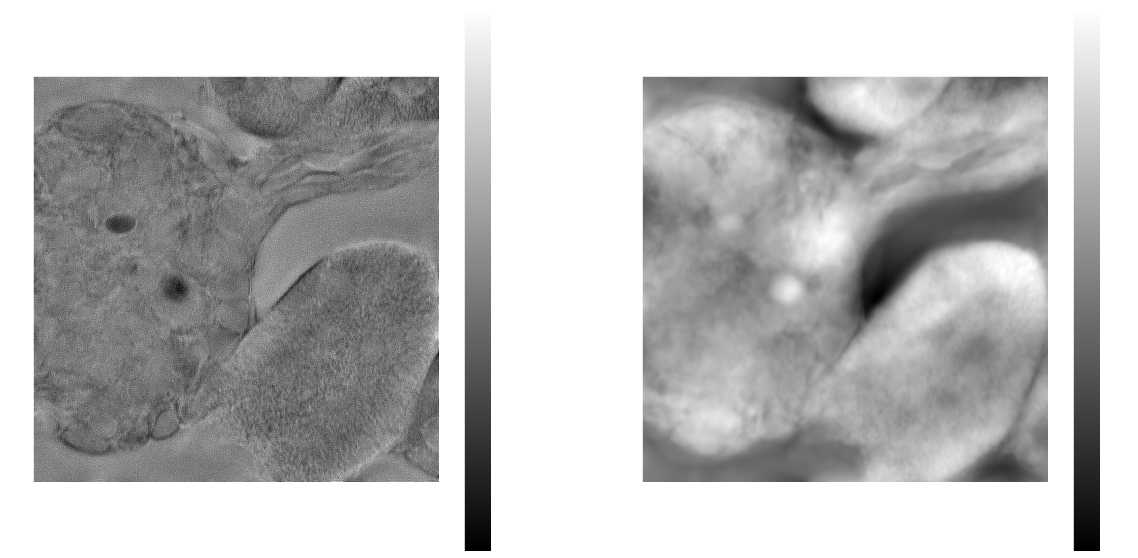

In [17]:

lambda_u = 1e-3
lambda_p = 1e-3
reg_u = 1e-3
reg_p = 1e-3

S0_stack = S_image_tm[0].copy()

mu_sample_TV, phi_sample_TV = setup.Phase_recon(S0_stack, method='TV', reg_u = reg_u, reg_p = reg_p, lambda_u = lambda_u, lambda_p = lambda_p, itr = 50, rho=1)

wo.plot_multicolumn(np.array([mu_sample_TV, phi_sample_TV]), num_col=2, size=10, \
                    set_title=True, titles = ['Reconstructed absorption', 'Reconstructed phase'])

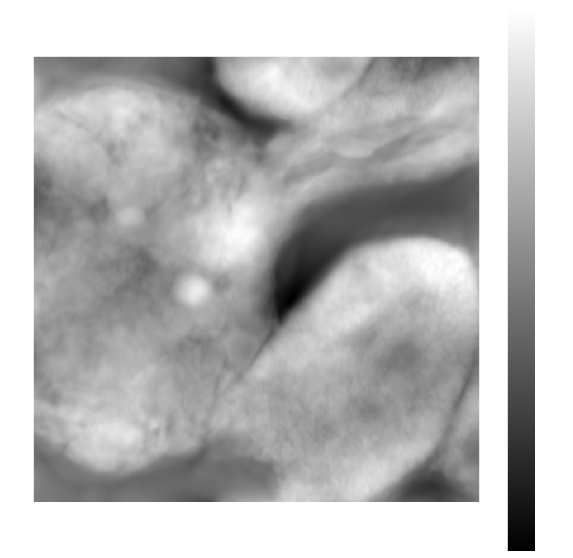

In [39]:

plt.figure(figsize=(10,10))
plt.imshow(phi_sample_TV, cmap='gray')
plt.colorbar()


In [19]:
gc.collect()
cp.get_default_memory_pool().free_all_blocks()

### 3D Phase reconstruction

In [20]:
S0_up =np.pad(S_image_tm[0],((0,0),(0,0),(5,5)), mode='constant',constant_values=S_image_tm[0].mean())

In [21]:
z_defocus_3D = -(np.r_[:55]-27)*0.25

setup_3D = wo.waveorder_microscopy((Ns,Ms), lambda_illu, ps, NA_obj, NA_illu, z_defocus_3D, chi,\
                                   n_media = n_media, cali=cali, bg_option=bg_option, \
                                   phase_deconv='3D', use_gpu=use_gpu, gpu_id=gpu_id)


In [22]:
gc.collect()
cp.get_default_memory_pool().free_all_blocks()

In [23]:
f_real = setup_3D.Phase_recon_3D(S0_up, absorption_ratio=0.0, method='Tikhonov', reg_re = 1e-4)


In [24]:
wo.image_stack_viewer(np.transpose(np.clip(f_real[:,:,5:-5]/(4*np.pi/lambda_illu),-0.05, 0.05),(2,0,1)), size=(15,15))

interactive(children=(IntSlider(value=0, description='stack_idx', max=44), Output()), _dom_classes=('widget-in…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

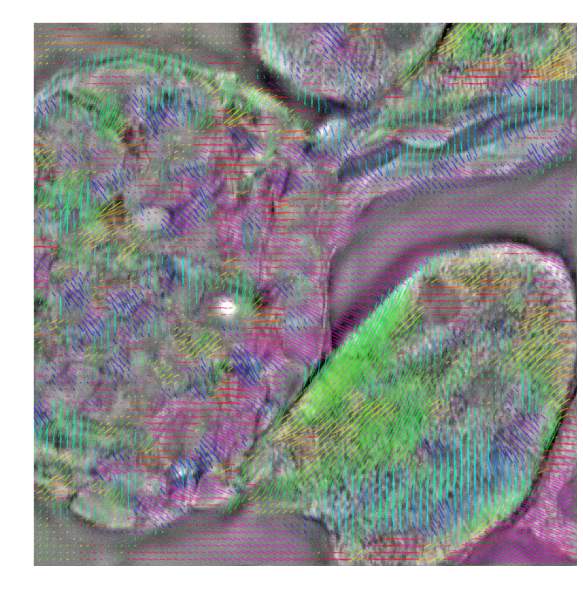

In [40]:
spacing = 10


max_phase = 0.05
min_phase = -0.05
max_ret = 2*np.pi*3e-3/lambda_illu

phase = np.clip((f_real[:,:,5:-5]/(4*np.pi/lambda_illu))[:,:,22], min_phase, max_phase)-min_phase
orientation = Recon_para[1,:,:,22]
ret = np.clip(Recon_para[0,:,:,22],0, max_ret)/max_ret



plt.figure(figsize=(10,10))
wo.plotVectorField(phase, orientation, anisotropy=ret, spacing=spacing, window=spacing, linelength=spacing*0.7, linewidth=2, linecolor='y', \
                   colorOrient=True, cmapOrient='hsv', threshold=None, alpha=0.5, clim=[None, None], cmapImage='gray')


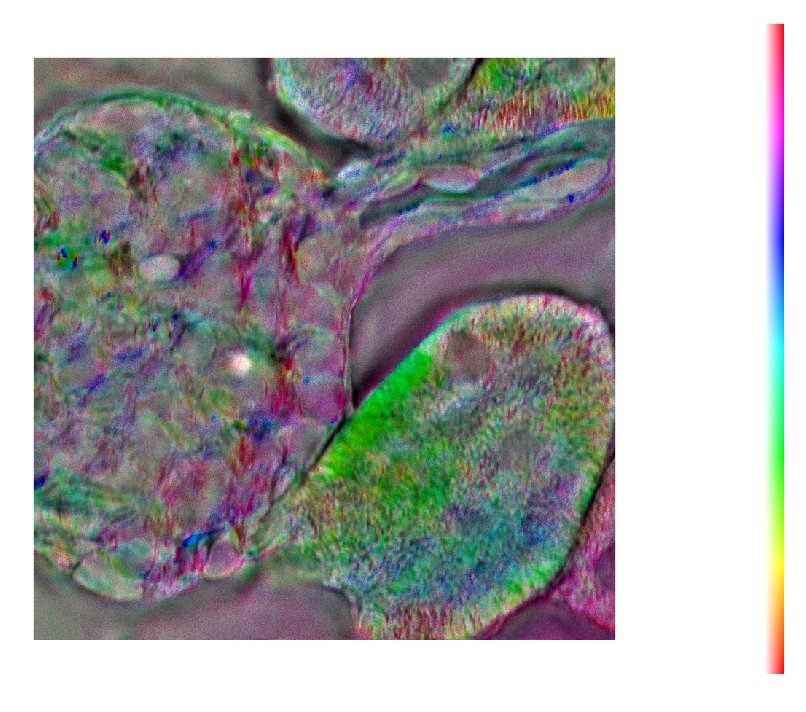

In [31]:
wo.plot_phase_hsv(np.array([orientation, ret, phase]), size=10)


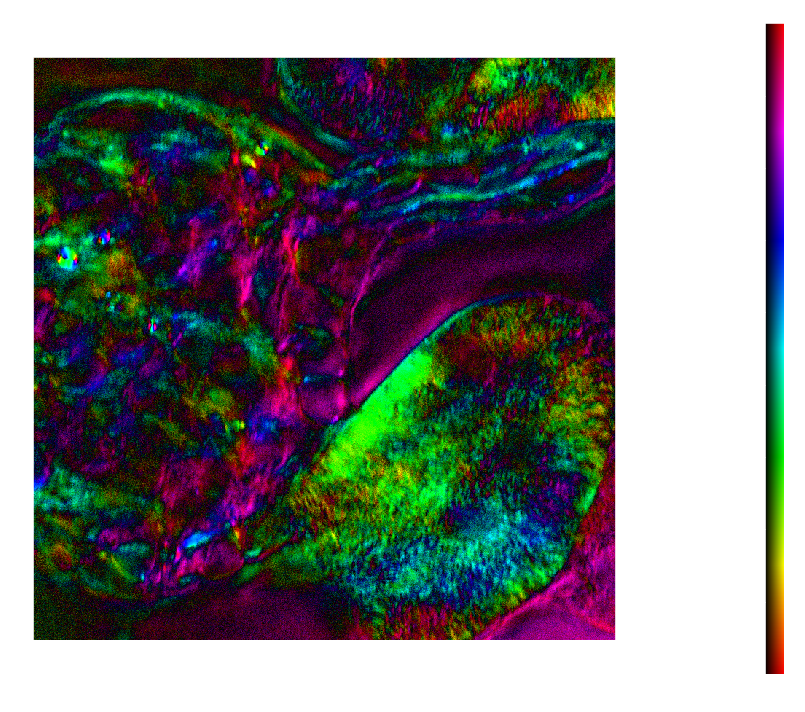

In [32]:
wo.plot_hsv(np.array([orientation, ret]), size=10)


In [33]:
gc.collect()
cp.get_default_memory_pool().free_all_blocks()

In [43]:
# save image stack in the folder

import os


image_stack = np.clip(f_real[:,:,5:-5]/(4*np.pi/lambda_illu),-0.05, 0.05)
dir_name = 'defocus'

os.system('mkdir '+dir_name)
N, M, N_frame = image_stack.shape
min_val = np.min(image_stack)
max_val = np.max(image_stack)


for i in range(N_frame):
    file_name=dir_name + '/kidney_tissue'+str(i)+'.tif'
    plt.imsave(file_name, image_stack[:,:,i], format="tiff", cmap=plt.cm.gray, vmin=min_val, vmax=max_val)

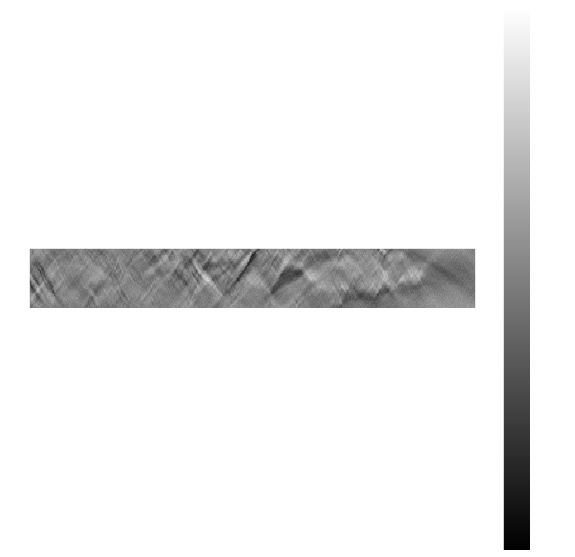

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(f_real[220,:,5:-5]/(4*np.pi/lambda_illu)), cmap='gray', extent=(-ps*Ms//2, ps*Ms//2, -z_step*N_defocus//2, z_step*N_defocus//2),clim=(-0.05,0.05))
plt.colorbar()

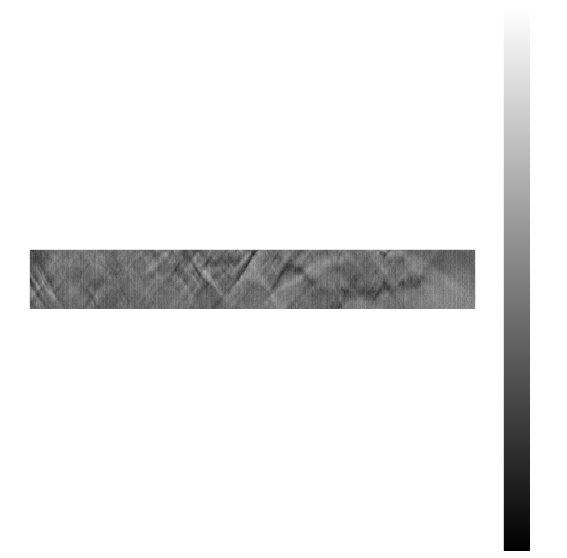

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(S0_stack[220,:,:]), cmap='gray', extent=(-ps*Ms//2, ps*Ms//2, -z_step*N_defocus//2, z_step*N_defocus//2),clim=(0.86,1.17))
plt.colorbar()

### Fluorescence data visualization

In [36]:
filedir_fl = data_path + '*405*.tif'
files_fl = sorted(glob.glob(filedir_fl), key=wo.numericalSort)


In [37]:
# Load background images


N_fl = len(files_fl)
I_fl = []

for i in range(0, N_fl):
    Itemp = io.imread(files_fl[i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
    I_fl.append(Itemp)

I_fl = np.maximum(0,np.array(I_fl)-150)

In [38]:
wo.image_stack_viewer(I_fl)

interactive(children=(IntSlider(value=0, description='stack_idx', max=44), Output()), _dom_classes=('widget-in…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

In [69]:
from matplotlib.colors import hsv_to_rgb

dir_name = 'defocus'
os.system('mkdir '+dir_name)


min_phase = -0.05
max_phase = 0.05
max_ret   = np.max(I_fl)/2


# norm_phase = np.clip(f_real[:,:,5:-5]/(4*np.pi/lambda_illu), min_phase, max_phase)-min_phase
norm_phase = np.clip(S_image_tm[0], np.min(S_image_tm[0]), np.max(S_image_tm[0])) - np.min(S_image_tm[0])
norm_phase /= np.max(norm_phase)

for i in range(45):

    bi_hsv_2 = np.transpose([0.3*np.ones_like(norm_phase[:,:,i]), \
                                       np.clip(I_fl[i,:,:]/max_ret,0,1), \
                                       norm_phase[:,:,i]], (1,2,0))



    bi_rgb_temp = hsv_to_rgb(bi_hsv_2.copy())
    bi_rgb_2 = bi_rgb_temp.copy()
    
    file_name=dir_name + '/kidney_tissue'+str(i)+'.tif'
    plt.imsave(file_name, bi_rgb_2, format="tiff")
#     plt.figure(figsize=(20,20))
#     plt.imshow(bi_rgb_2)